# CIS580 Final Homework

## 1. Two View Stereo

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import cv2

EPS = 1e-8

from utils import viz_camera_poses

### 1.0 Load Data

Note: you can uncomment the `viz_camera_poses([view_i, view_j])` to interactively understand the camera configuration, you will get some coordinates colored R-X, G-Y, B-Z. Press `i` in the interactive pyrender window to show the world coordinate.

You will find that in the world frame, for each camera, X+ direction is vertically upward, the Y+ direction towards the right, and the Z+ forward.

You will get views that are lying horizontally. In each image, the left-up corner has integer pixel coordinate [u,v] = [0,0]. The first index/row index of the image corresponds to Y or v, and the second index/col index of the image corresponds to X or u.

Loading data/templeRing


0it [00:00, ?it/s]

47it [00:01, 40.92it/s]


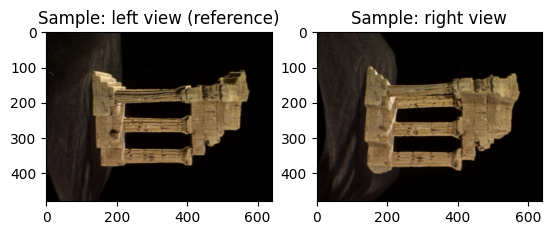

In [3]:
# Load data
from dataloader import load_middlebury_data
DATA = load_middlebury_data("data/templeRing")
# reference: https://vision.middlebury.edu/mview/

view_i, view_j = DATA[0], DATA[3]
viz_camera_poses([view_i, view_j])

plt.subplot(1, 2, 1)
plt.title("Sample: left view (reference)")
plt.imshow(view_i["rgb"])
plt.subplot(1, 2, 2)
plt.title("Sample: right view")
plt.imshow(view_j["rgb"])
plt.show()

### 1.1 Rectify two views

<!-- Complete the function `compute_right2left_transformation` and `compute_rectification_R`; we have implemented the calibration `rectify_2view`  for you after you get the `R_irect` -->

In [4]:
from two_view_stereo import (
    rectify_2view,
    compute_rectification_R,
    compute_right2left_transformation,
)

i_R_w, i_T_w = view_i["R"], view_i["T"][:, None]  # p_i = i_R_w @ p_w + i_T_w
j_R_w, j_T_w = view_j["R"], view_j["T"][:, None]  # p_j = j_R_w @ p_w + j_T_w

i_R_j, i_T_j, B = compute_right2left_transformation(i_R_w, i_T_w, j_R_w, j_T_w)
assert i_T_j[1, 0] > 0, "here we assume view i should be on the left, not on the right"

rect_R_i = compute_rectification_R(i_T_j)

rgb_i_rect, rgb_j_rect, K_i_corr, K_j_corr = rectify_2view(
    view_i["rgb"],
    view_j["rgb"],
    rect_R_i,
    rect_R_i @ i_R_j,
    view_i["K"],
    view_j["K"],
    u_padding=20,
    v_padding=20,
)

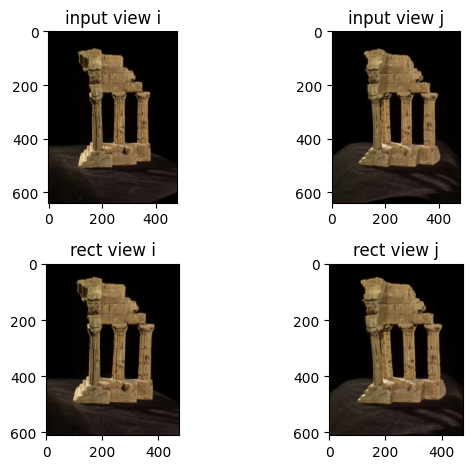

In [12]:
plt.subplot(2, 2, 1)
plt.title("input view i")
plt.imshow(cv2.rotate(view_i["rgb"], cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.subplot(2, 2, 2)
plt.title("input view j")
plt.imshow(cv2.rotate(view_j["rgb"], cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.subplot(2, 2, 3)
plt.title("rect view i")
plt.imshow(cv2.rotate(rgb_i_rect, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.subplot(2, 2, 4)
plt.title("rect view j")
plt.imshow(cv2.rotate(rgb_j_rect, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.tight_layout()
plt.show()

### 1.2 Compute the disparity

In [44]:
from two_view_stereo import image2patch, ssd_kernel

assert K_i_corr[1, 1] == K_j_corr[1, 1], "This hw assumes the same focal Y length"
assert (K_i_corr[0] == K_j_corr[0]).all(), "This hw assumes the same K on X dim"
assert (
    rgb_i_rect.shape == rgb_j_rect.shape
), "This hw makes rectified two views to have the same shape"

h, w = rgb_i_rect.shape[:2]

d0 = K_j_corr[1, 2] - K_i_corr[1, 2]

patches_i = image2patch(rgb_i_rect.astype(float) / 255.0, 3)  # [h,w,k*k,3]
patches_j = image2patch(rgb_j_rect.astype(float) / 255.0, 3)  # [h,w,k*k,3]

vi_idx, vj_idx = np.arange(h), np.arange(h)
disp_candidates = vi_idx[:, None] - vj_idx[None, :] + d0
valid_disp_mask = disp_candidates > 0.0

# as an example
u = 400

buf_i, buf_j = patches_i[:, u], patches_j[:, u]
value = ssd_kernel(buf_i, buf_j)  # each row is one pix from left, col is the disparity
# Students, why we compute this `_upper` ?
_upper = value.max() + 1.0
value[~valid_disp_mask] = _upper


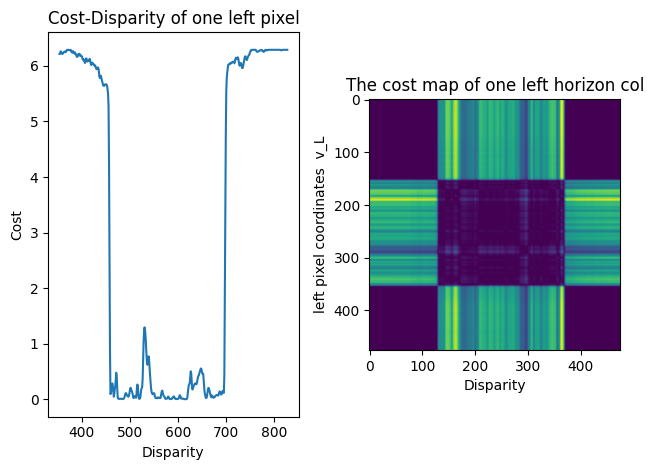

In [45]:
plt.subplot(1,2,1)
# Viz the  disparity-cost of u=500, v=200 on left view
v = 200
plt.title("Cost-Disparity of one left pixel")
plt.xlabel("Disparity")
plt.ylabel("Cost")
plt.plot(disp_candidates[v], value[v])
plt.subplot(1,2,2)
plt.title("The cost map of one left horizon col")
plt.xlabel("Disparity")
plt.ylabel("left pixel coordinates  v_L")
plt.imshow(value)
plt.tight_layout()
plt.show()

Now let's do the Left-Right consistency: in above right figure, the vertical axis is the left pixel coordinates and the horizontal axis is the right pixel (disparity). 

When we find the minimal cost right view pixel for our reference pixel (e.g. find the minimum of the left figure), we only check the best matched right pixel patch, which corresponds to finding the minimum along the horizontal axis of the right cost map. 

However, the matching from the left to the right and from the right to the left should be consistent.
So we should also check the minimum of the vertical axis and see whether this two minimum agree with each other, below is an example

In [46]:
# example for the pixel (u=500,v=300) from the left view
v = 300
best_matched_right_pixel = value[v].argmin()
best_matched_left_pixel = value[:,best_matched_right_pixel].argmin()
print(v, best_matched_left_pixel)
consistent_flag = best_matched_left_pixel == v
print(consistent_flag)

# example for the pixel (u=500,v=380) from the left view
v = 380
best_matched_right_pixel = value[v].argmin()
best_matched_left_pixel = value[:,best_matched_right_pixel].argmin()
print(v, best_matched_left_pixel)
consistent_flag = best_matched_left_pixel == v
print(consistent_flag)


300 300
True
380 113
False


Based on above example, iterate over all u, complete the function `compute_disparity_map`.

Tips: for vectorized operation, you may use `take_along_axis` with `argmin` from numpy, please check the documentation from numpy to understand how to use the function

In [48]:
from two_view_stereo import compute_disparity_map

disp_map, consistency_mask = compute_disparity_map(
    rgb_i_rect, rgb_j_rect, d0=K_j_corr[1, 2] - K_i_corr[1, 2], k_size=5
)


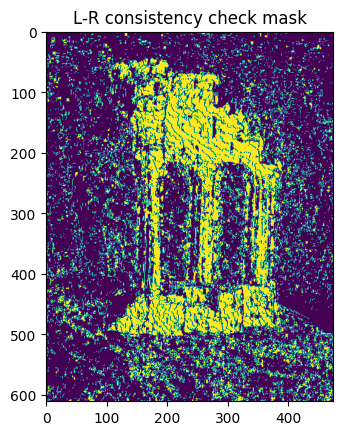

In [49]:
plt.imshow(cv2.rotate(consistency_mask, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.title("L-R consistency check mask")
plt.show()

### 1.3 Compute the depth map and point cloud reconstruction

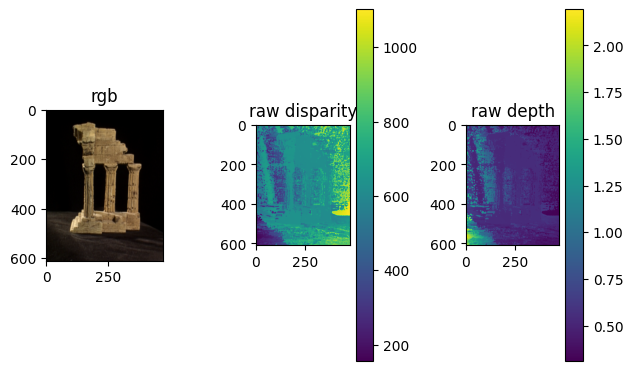

In [61]:
from two_view_stereo import compute_dep_and_pcl

# * 3. compute depth map and filter them
dep_map, xyz_cam = compute_dep_and_pcl(disp_map, B, K_i_corr)

plt.subplot(1, 3, 1)
plt.title("rgb")
plt.imshow(cv2.rotate(rgb_i_rect, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.subplot(1, 3, 2)
plt.title("raw disparity")
plt.imshow(cv2.rotate(disp_map, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title("raw depth")
plt.imshow(cv2.rotate(dep_map, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.colorbar()
plt.tight_layout()
plt.show()


### 1.4 Postprocessing and visualization

[[-0.05728767 -0.02485251 -0.06357588]
 [-0.05729199 -0.02446977 -0.06364685]
 [-0.05642558 -0.02461079 -0.06270953]
 ...
 [ 0.08566729 -0.0600931  -0.06812632]
 [ 0.08590396 -0.0605383  -0.06707065]
 [ 0.08589974 -0.06016399 -0.06714005]]


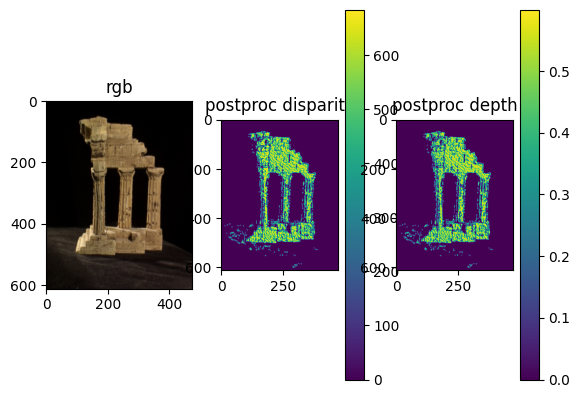

In [71]:
from two_view_stereo import postprocess

mask, pcl_world, pcl_cam, pcl_color = postprocess(
    dep_map,
    rgb_i_rect,
    xyz_cam,
    c_R_w=rect_R_i @ i_R_w,
    c_T_w=rect_R_i @ i_T_w,
    consistency_mask=consistency_mask,
    z_near=0.5,
    z_far=0.6,
)

mask = (mask > 0).astype(float)

plt.subplot(1, 3, 1)
plt.title("rgb")
plt.imshow(cv2.rotate(rgb_i_rect, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.subplot(1, 3, 2)
plt.title("postproc disparity")
plt.imshow(cv2.rotate(disp_map * mask, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title("postproc depth")
plt.imshow(cv2.rotate(dep_map * mask, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.colorbar()
plt.show()


Visualization code below, use whichever function works to visually inspect your work:

In [67]:
import k3d
import numpy as np
## IMPORTANT: if running K3D on Google Colab, be sure to uncomment the following lines:
### COLAB SETUP ###
# from google.colab import output
# output.enable_custom_widget_manager()
# k3d.switch_to_text_protocol()
###################
def viz_3d_embedded(pcl, color):
    plot = k3d.plot(camera_auto_fit=True)
    color = color.astype(np.uint8)
    color32 = (color[:, 0] * 256**2 + color[:, 1] * 256**1 + color[:, 2] * 256**0).astype(
        np.uint32
    )
    plot += k3d.points(pcl.astype(float), color32, point_size=0.001, shader="flat")
    plot.display()

### IMPORTANT: uncomment the function below to replace the `viz_3d_embedded` function if the above implementation fails
# import plotly.graph_objects as go
# def viz_3d_embedded(point_cloud, colors=None):
#     fig = go.Figure()
#     x, y, z = point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2]
#     if colors is not None:
#         fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=0.75, color=colors)))
#     else:
#         fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=0.75)))

#     fig.update_layout(scene=dict(aspectmode="data"))
#     fig.show()

#### SSD Two view reconstruction results

In [68]:
viz_3d_embedded(pcl_world, pcl_color.astype(np.uint8))

/home/saichand44/.local/lib/python3.8/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(


Output()

#### SAD Two view reconstruction results
<!-- ### 1.5 Put things together and try different Similarity -->

In [72]:
from two_view_stereo import two_view ,sad_kernel

pcl_sad, pcl_color_sad, disp_map_sad, dep_map_sad = two_view(DATA[0], DATA[2], 5, sad_kernel)
viz_3d_embedded(pcl_sad, pcl_color_sad.astype(np.uint8))

100%|██████████| 606/606 [01:55<00:00,  5.26it/s]


Output()

#### ZNCC Two view reconstruction results

In [73]:
from two_view_stereo import two_view, zncc_kernel

pcl_zncc, pcl_color_zncc, disp_map_zncc, dep_map_zncc = two_view(DATA[0], DATA[2], 5, zncc_kernel)
viz_3d_embedded(pcl_zncc, pcl_color_zncc.astype(np.uint8))


100%|██████████| 606/606 [01:26<00:00,  7.03it/s]


Output()

### 1.5 Aggregation

In [74]:
from two_view_stereo import two_view, ssd_kernel, sad_kernel, zncc_kernel

pcl_list, pcl_color_list, disp_map_list, dep_map_list = [], [], [], []
pairs = [(0, 2), (2, 4), (5, 7), (8, 10), (13, 15), (16, 18), (19, 21), (22, 24), (25, 27)]
# for i in range(13, 28, 3):
for pair in pairs:
    i,j = pair
    _pcl, _pcl_color, _disp_map, _dep_map = two_view(DATA[i], DATA[j], 5, sad_kernel)
    pcl_list.append(_pcl)
    pcl_color_list.append(_pcl_color)
    disp_map_list.append(_disp_map)
    dep_map_list.append(_dep_map)

100%|██████████| 606/606 [01:46<00:00,  5.72it/s]


In [75]:
plot = k3d.plot(camera_auto_fit=True)
for pcl, color in zip(pcl_list, pcl_color_list):
    color = color.astype(np.uint8)
    color32 = (color[:, 0] * 256**2 + color[:, 1] * 256**1 + color[:, 2] * 256**0).astype(
        np.uint32
    )
    plot += k3d.points(pcl.astype(float), color32, point_size=0.001, shader="flat")
plot.display()

## NOTE: alternative with plotly function:
# point_cloud = np.concatenate(pcl_list, axis=0)
# colors = np.concatenate(pcl_color_list, axis=0)
# viz_3d_embedded(point_cloud, colors.astype(np.uint8))

Output()